In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
setup_cols = [
    'experiment_id', 
    'dist_graph_create',
    'neighbour_all_to_all_v', 
    'tree_all_to_all',
    'source_tree',
    'target_tree',
    'tree_all_gather',
    'n_points'
]

runtime_cols = [
    'experiment_id', 
    'runtime', 
    'p2p', 
    'm2l', 
    'scatter_v_runtime',
    'gather_v_runtime',
    'neighbour_all_to_all_v_runtime', 
    'n_points'
]

In [22]:
df0 = pd.read_csv('data/full/strong_fft_n=128000000_p=64_points_per_rank=62500_distribution=uniform_11277038.csv')
df1 = pd.read_csv('data/full/strong_fft_n=128000000_p=64_points_per_rank=125000_distribution=uniform_11277036.csv')
df2 = pd.read_csv('data/full/strong_fft_n=128000000_p=64_points_per_rank=1000000_distribution=uniform_11278285.csv')

df3 = pd.read_csv('data/full/strong_fft_n=128000000_p=64_points_per_rank=62500_distribution=sphere_11277037.csv')
df4 = pd.read_csv('data/full/strong_fft_n=128000000_p=64_points_per_rank=125000_distribution=sphere_11277035.csv')
df5 = pd.read_csv('data/full/strong_fft_n=128000000_p=64_points_per_rank=1000000_distribution=sphere_11277039.csv')

In [115]:
def strong_scaling(dfs, names=None, title="Strong Scaling and Parallel Efficiency", plot_err=True, y_scale='linear', stat='mean'):
    """
    Plots strong scaling (runtime) and parallel efficiency for one or more DataFrames.

    Parameters
    ----------
    dfs : list of pandas.DataFrame or pandas.DataFrame
        One or more DataFrames with columns including:
        ['experiment_id', 'runtime', 'p2m', 'm2l', 'm2m', 'l2l', 'source_tree', 'n_points', 'source_local_trees_per_rank']
    names : list of str, optional
        Names/labels for each DataFrame. Must be same length as dfs.
    title : str
        Title for the figure.
    """

    # Handle single DataFrame input
    if not isinstance(dfs, (list, tuple)):
        dfs = [dfs]
    if names is None:
        names = [f"Run {i+1}" for i in range(len(dfs))]

    # Style setup
    sns.set_context("talk", font_scale=1.1)
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    ax_runtime, ax_eff = axes

    # Marker and color configuration
    markers = ['o', 's', '^', 'D', 'v', 'P', '*']
    colors = sns.color_palette("deep", len(dfs))

    for df, label, color, marker in zip(dfs, names, colors, markers):
        stats = df.groupby('experiment_id')[['runtime', 'p2m', 'm2l', 'm2m', 'l2l', 'source_tree', 'n_points', 'source_local_trees_per_rank']]
        n_ranks = stats.size()

        if stat == "mean":
            runtime = stats.mean()['runtime']
        elif stat == "median":
            runtime = stats.median()['runtime']
        elif stat == "max":
            runtime = stats.max()['runtime']
        else:
            raise ValueError("Only supports 'mean' or 'median'")
    
        runtime_err = stats.std()['runtime']

        # Ideal scaling
        T1 = runtime.iloc[0]
        ideal_runtime = [T1 / (n_ranks.iloc[i] / n_ranks.iloc[0]) for i in range(len(n_ranks))]

        # Parallel efficiency
        efficiency = (T1 / (runtime * (n_ranks / n_ranks.iloc[0]))) * 100  # in %

        n_points = stats.mean()['n_points'] # points per rank

        # Runtime plot
        if plot_err:
            ax_runtime.errorbar(
                n_points, runtime, yerr=runtime_err, fmt=marker+'-', color=color,
                label=label, capsize=4, linewidth=2, markersize=7
            )
        else:
            ax_runtime.plot(
                n_points, runtime,  marker=marker, color=color,
                label=label, linewidth=2, markersize=7
            )
        ax_runtime.plot(n_points, ideal_runtime, '--', color=color, alpha=0.7, linewidth=1.5)

        # Efficiency plot
        ax_eff.plot(
            n_points, efficiency, marker=marker, linestyle='-', color=color,
            label=label, linewidth=2, markersize=7
        )

        ax_eff.xaxis.set_inverted(True) 
        ax_runtime.xaxis.set_inverted(True) 


    # Configure runtime plot
    ax_runtime.set_xscale("log", base=2)
    if y_scale == "log":
        ax_runtime.set_yscale("log")
    ax_runtime.set_xlabel("Points Per Rank", fontsize=13)
    ax_runtime.set_ylabel("Runtime (ms)", fontsize=13)
    ax_runtime.set_title("Strong Scaling (Runtime)", fontsize=14)
    ax_runtime.grid(True, which="both", ls="--", lw=0.5)
    ax_runtime.legend(fontsize=11)

    # Configure efficiency plot
    ax_eff.set_xscale("log", base=2)
    ax_eff.set_ylim(0, 110)
    ax_eff.set_xlabel("Points Per Rank", fontsize=13)
    ax_eff.set_ylabel("Parallel Efficiency (%)", fontsize=13)
    ax_eff.set_title("Parallel Efficiency", fontsize=14)
    ax_eff.grid(True, which="both", ls="--", lw=0.5)
    ax_eff.legend(fontsize=11)

    fig.suptitle(title, fontsize=16, y=1.03)
    plt.tight_layout()
    plt.show()


def breakdown_communication_times(df, stat='max', y_scale="linear"):
    
    stats = df.groupby('experiment_id')[runtime_cols]
    n_ranks = stats.size()
    n_points = stats.mean()['n_points'] * n_ranks

    if stat == "max":
        tmp = stats.max()
    elif stat == "mean":
        tmp = stats.mean()
    elif stat == "median":
        tmp = stats.median()
    else:
        return ValueError("invalid stat")
    
    tmp = tmp.set_index(n_ranks)
    
    # Total communication time per experiment
    tmp['comm_time'] = tmp[['scatter_v_runtime', 'gather_v_runtime', 'neighbour_all_to_all_v_runtime']].sum(axis=1)
    
    x = tmp.index.values.astype(float)
    y = tmp['comm_time'].values
    # c = y[-1]

    # # log_curve
    # # log_curve = y[-1] * np.emath.logn(8, x / x[0]) + y[0]
    # m = (c-y)/np.emath.logn(8,x)
    # log_curve = -m*x + c
    
    # # linear curve
    # m = (c-y)/x
    # linear_curve = -m*x + c
    # log_curve = y[-1] * (np.emath.logn(8, x[-1]) / np.emath.logn(8, x))
    # linear_curve = y[-1] * (x[-1] / x)
    
    # Stacked bar for measured communication time
    fig, ax = plt.subplots(figsize=(10, 6))
    tmp[['scatter_v_runtime', 'gather_v_runtime', 'neighbour_all_to_all_v_runtime']].plot(
        kind="bar", stacked=True, ax=ax, colormap="tab20"
    )
        
    ax.set_xticks(range(len(x)))
    ax.set_xticklabels([int(v) for v in x], rotation=0)
    ax.set_xlabel("Number of MPI Ranks")
    ax.set_ylabel("Runtime Communication (ms)")
    
    # ax.set_yscale('log')
    if y_scale == "log":
        ax_runtime.set_yscale('log')
    
    # Overlay both theoretical trends, starting from first value
    # ax.plot(range(len(x)), log_curve, color="red", marker="o", linestyle="--", label="~ log(p) scaling")
    # ax.plot(range(len(x)), linear_curve, color="green", marker="s", linestyle="--", label="~ O(p) scaling")
    
    # Style cleanupr
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

# Plot Strong Scaling

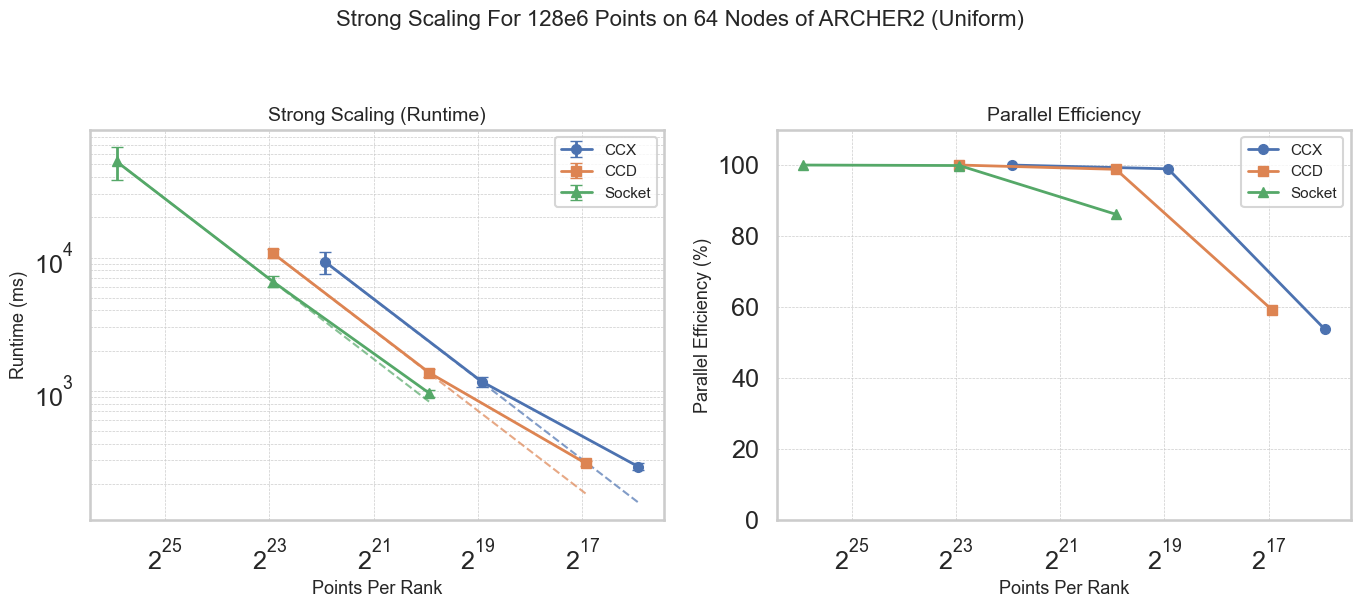

In [117]:
strong_scaling([df0,df1,df2], names=["CCX", "CCD","Socket"], title="Strong Scaling For 128e6 Points on 64 Nodes of ARCHER2 (Uniform)", plot_err=True, stat='max', y_scale='log')

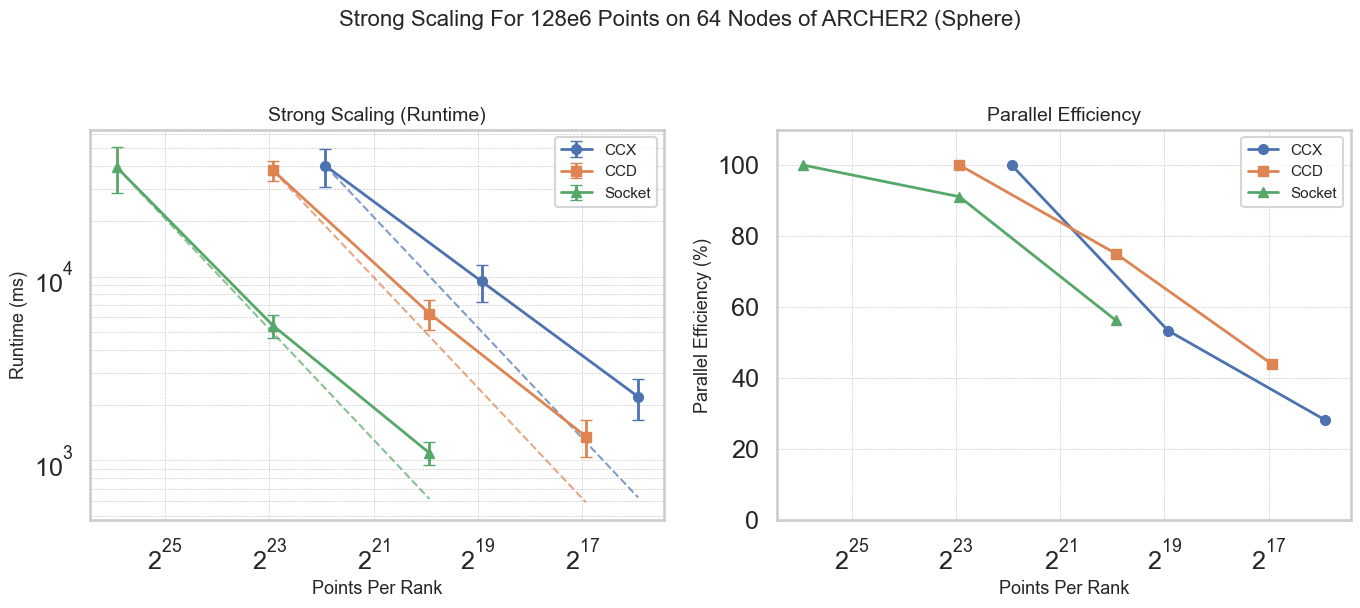

In [119]:
strong_scaling([df3,df4,df5], names=["CCX", "CCD","Socket"], title="Strong Scaling For 128e6 Points on 64 Nodes of ARCHER2 (Sphere)", stat='max', y_scale='log')

# Plot Communication Breakdown

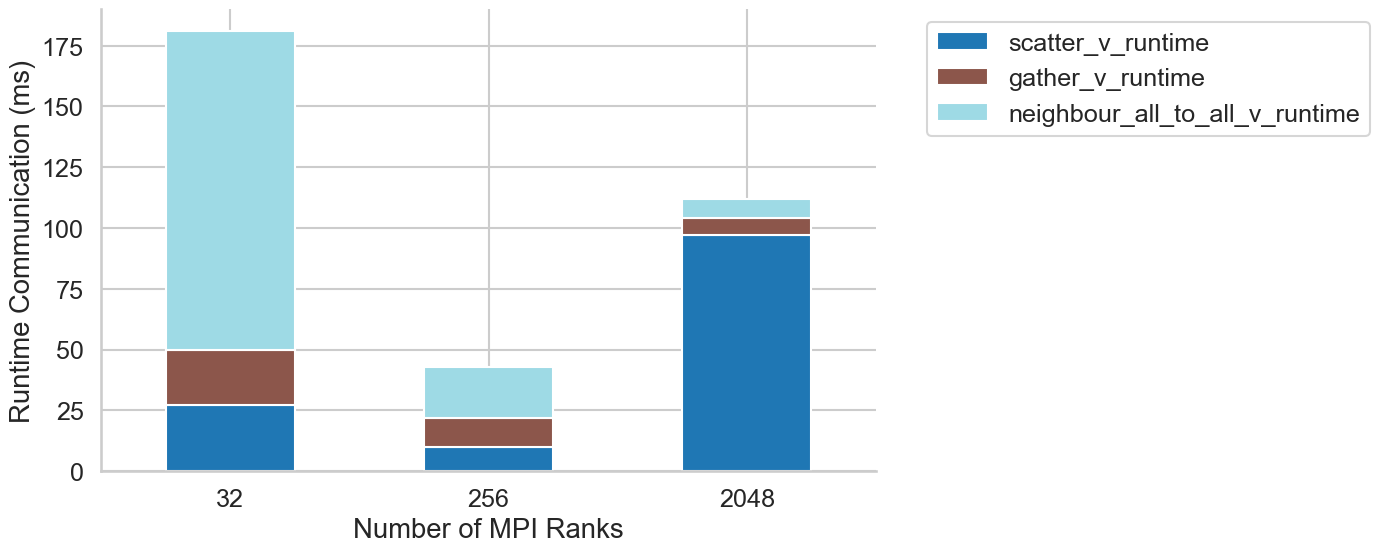

In [130]:
breakdown_communication_times(df0, stat='max')